# Create K-Means clustering for homogeneous Phenology clases.

Author: Javier Lopatin \
Date: 2025-11-10 \
Version: 1.0 


In [1]:
# import funcitons to perform KMeans clustering
import os
from sklearn.cluster import KMeans
import rioxarray as rio
import matplotlib.pyplot as plt
import numpy as np
import pickle
from yellowbrick.cluster import KElbowVisualizer
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar

#from dask.distributed import Client
#client = Client()
#client

In [ ]:
# set working directory
os.chdir("/mnt/rapidita_4T/temp/Suisun/")
os.getcwd()

In [2]:
# functions to be used 

def xarray_to_2D(data):
    '''
    Function to convert xarray to 2D array
    '''
    data = data.stack(z=('y','x'))
    data = data.transpose('z', 'band')
    data.values = np.nan_to_num(data.values)
    return data

def pred_to_xarray(model, data, output_bands=1):
    '''
    Function to convert the prediction array to a xarray
    '''
    # transform the encoded data to a 3D array
    # template with the xarray shape
    template = data[:, 1]
    template
    # assign the encoded data to the template
    output_array = template.copy(data=model)
    # unstack xarray to get the original shape
    return output_array.unstack()

def test_cluster(X_pca):
    '''function to test KMeans clustering with different number of clusters'''
    # Instantiate the clustering model and visualizer
    print('Processing clusters...')
    model = KMeans(random_state=42)
    elb_visualizer = KElbowVisualizer(model, k=(4,13), metric='calinski_harabasz')# calinski_harabasz
    elb_visualizer.fit(X_pca)
    elb_visualizer.show()
    plt.savefig('figures/KMeans_elbow.png', dpi=300)
    return elb_visualizer

def predict_cluster(data_na, data, n_clusters):
    '''
    function to predict KMeans clustering
    Fits model using data without NaN values
    Predicts on data with NaN values converted to zeros
    '''
    cluster_model = KMeans(n_clusters=n_clusters, random_state=42).fit(data_na)
    cluster_model = cluster_model.predict(data)
    return cluster_model + 1 # add 1 to avoid 0 values

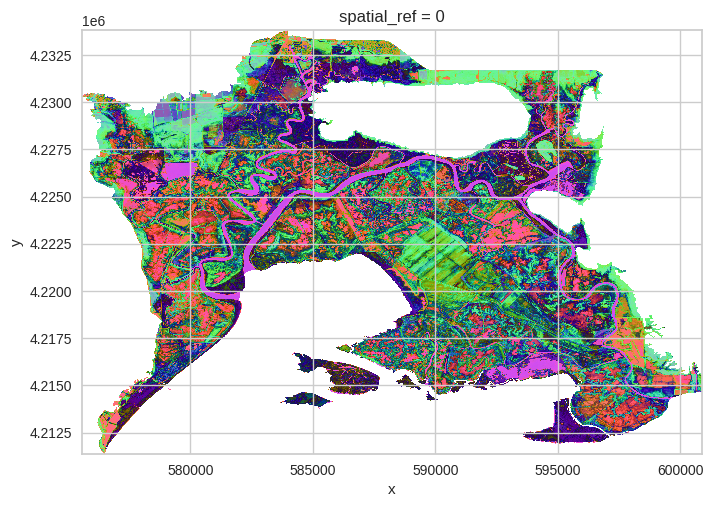

In [3]:
# load KernelPCA raster
inputData = 'KernelPCA_clip'
img = rio.open_rasterio('Rasters/'+inputData+'.tif')
img.plot.imshow(robust=True)

In [16]:
img.rio.crs

CRS.from_epsg(32610)

In [27]:
# open shapefile
shp = gpd.read_file('SHP/Suisun_PFT_diss.shp')

# mask Agriculture and Urban from PFT
shp = shp[shp['PFT'] != 'Agriculture']
shp = shp[shp['PFT'] != 'Urban or developed']
shp.PFT

1                            Barren
2                               Bay
3                         Grassland
4                             Other
5     Pickleweed-Cordgrass-Saltbush
6                      Tule-Cattail
8                             Water
9                       Wet Meadows
10                           Willow
Name: PFT, dtype: object

In [6]:
shp.crs

<Derived Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

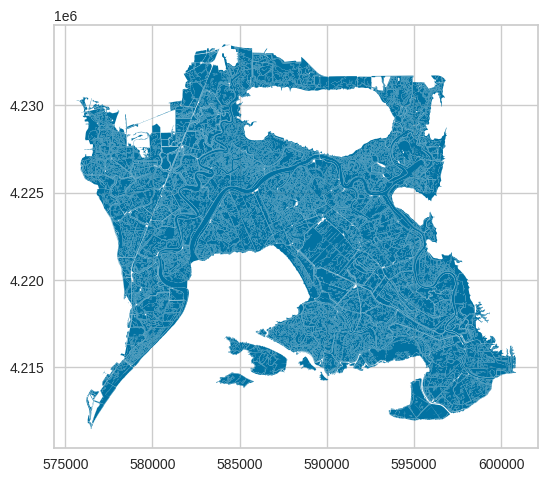

In [7]:
shp.plot()

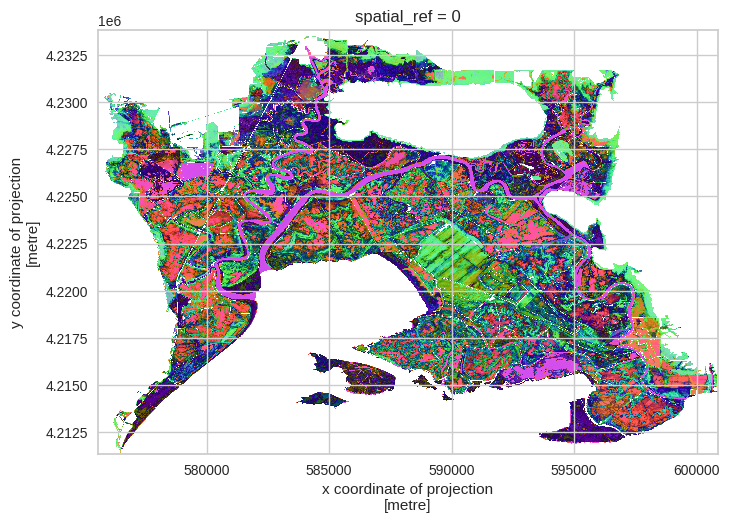

In [8]:
# crop image with shp
img_cropped = img.rio.clip(shp.geometry, shp.crs, drop=False)
img_cropped.plot.imshow(robust=True)

In [10]:
# Convert the raster data to a 2D array and re-organize the data
data = xarray_to_2D(img_cropped)
# delete rows with NaN values in data
data_na = data.dropna(dim='z', how='any')

Processing clusters...


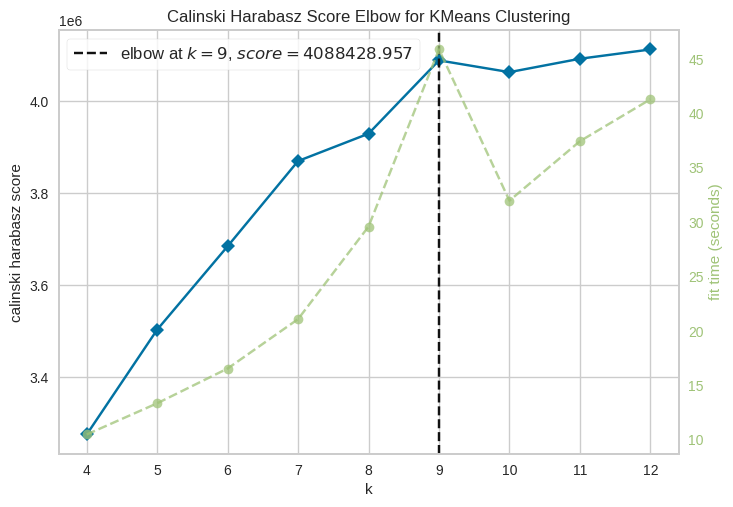

<Figure size 800x550 with 0 Axes>

In [46]:
visualizer = test_cluster(data_na)

In [11]:
# predict best number of clusters
n_clusters=9
cluster_model = predict_cluster(data_na, data, n_clusters=n_clusters)
cluster_model

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

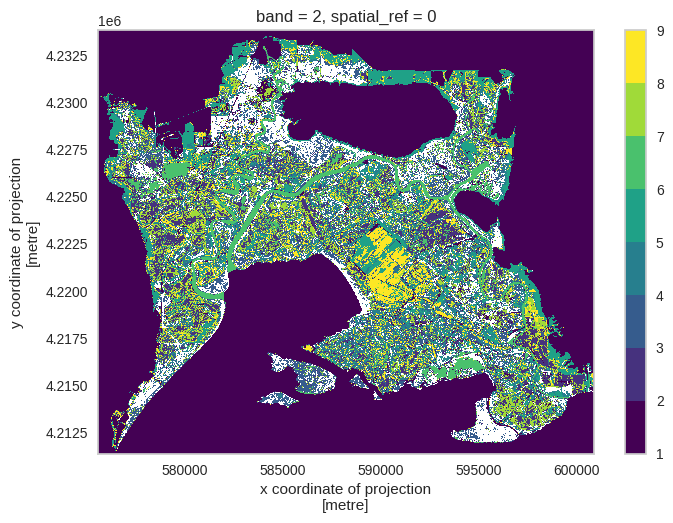

In [12]:
# prediction to xarray
prediction = pred_to_xarray(cluster_model, data, output_bands=1)
prediction.plot(levels=n_clusters+1)

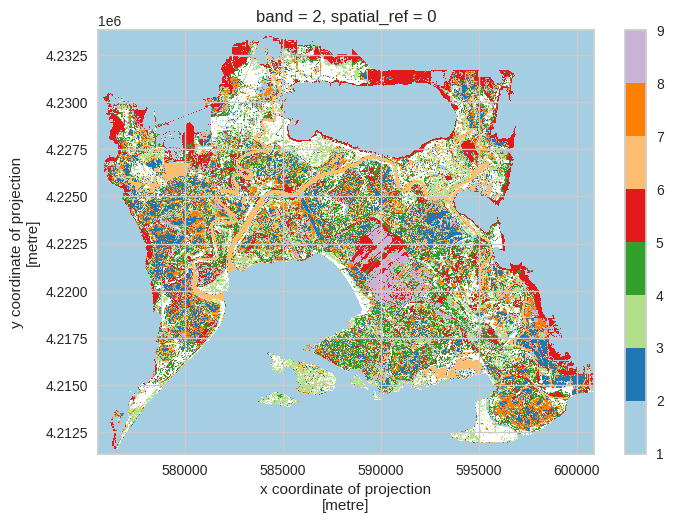

In [50]:
# Creating a colormap from the given colors
col = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
cmap = colors.ListedColormap(col)

prediction.plot.imshow(levels=n_clusters+1, cmap=cmap)

In [10]:
# save cluster_model to disk for later use
filename = 'models/cluster_model_'+inputData+'_'+str(n_clusters)+'.sav'
pickle.dump(cluster_model, open(filename, 'wb'))

In [15]:
# mask out non wanted classes
prediction = prediction.astype('float') # allow NaN values
prediction_clip = prediction.rio.clip(shp.geometry, shp.crs, drop=False)

In [5]:
# load again if needed
prediction_clip = rio.open_rasterio('Rasters/kmenas_KernelPCA_clip_9.tif').squeeze()

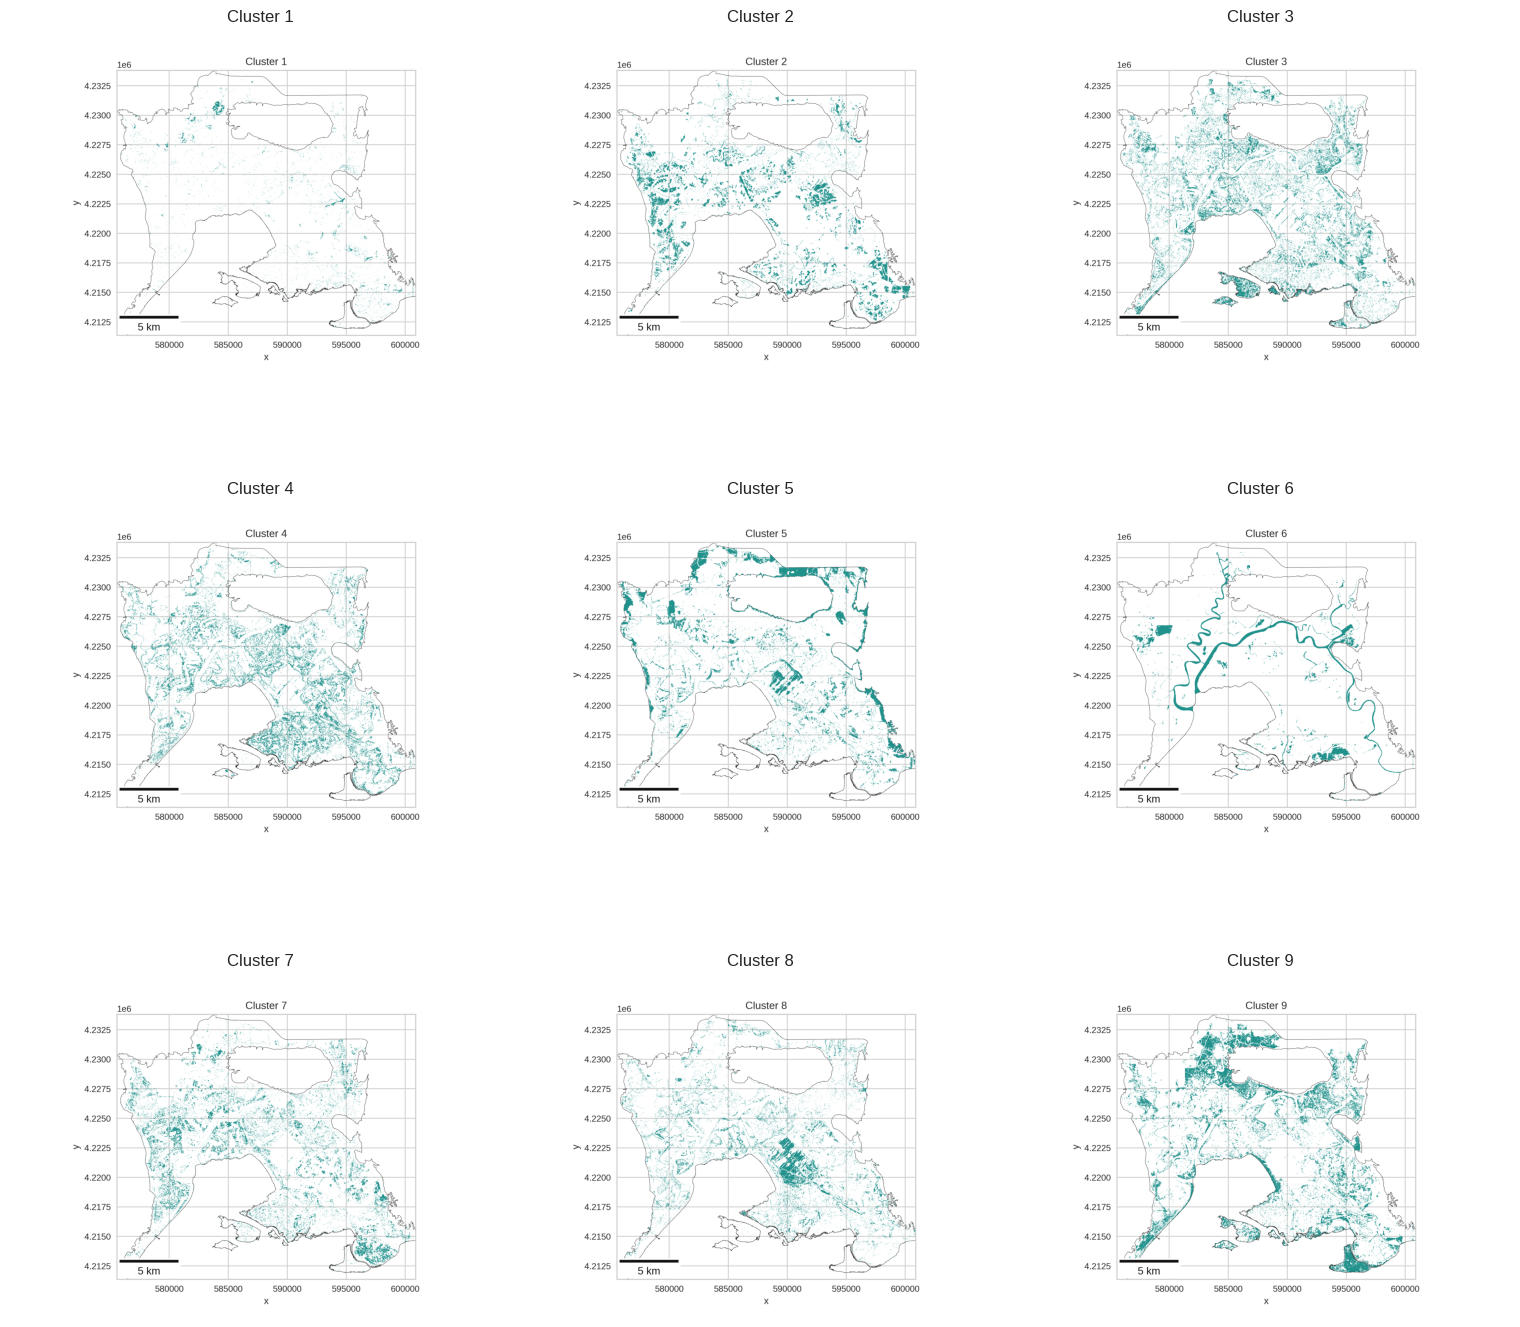

In [68]:
# plot each cluster separatlely as a mask

countour = gpd.read_file('SHP/Suisun_PFT_diss_diss.shp')
n_clusters = 9

# Create a 3x3 grid for final combined figure
combined_fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i in range(n_clusters):
    # Individual figure for each cluster
    fig, ax = plt.subplots()
    countour.plot(ax=ax, facecolor='none', edgecolor='black')

    # Plot the prediction_clip data
    prediction_clip.where(prediction_clip == i+1).plot(ax=ax, add_colorbar=False)
    plt.title('Cluster ' + str(i+1))

    # Add scale bar to the bottom left
    scalebar = ScaleBar(1, location=3)
    ax.add_artist(scalebar)

    outname = 'figures/map_cluster_' + str(i+1) + '.png'
    #plt.savefig(outname, dpi=300)
    
    # Load the saved PNG to the combined 3x3 grid
    img = plt.imread(outname)
    row = i // 3
    col = i % 3
    axs[row, col].imshow(img)
    axs[row, col].axis('off')  # Turn off axis numbers and ticks
    axs[row, col].set_title('Cluster ' + str(i+1))
    
    plt.close(fig)  # Close the individual figure to free up memory

plt.tight_layout(pad=0)
plt.savefig('figures/all_classes2.png', dpi=300)


In [5]:
# save a tiff of cluster separatlely as a mask

n_clusters = 9

for i in range(n_clusters):
    img = prediction_clip.where(prediction_clip == i+1)
    img.rio.to_raster('Rasters/cluster_'+str(i+1)+'.tif')


Text(0.5, 1.0, 'My Custom Title')

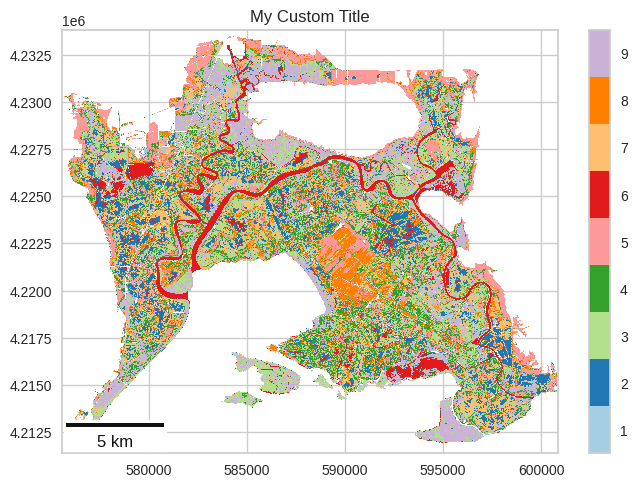

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import colors

def plot_classes(class_map, n_clusters, col=None):
    """
    Plot a prediction array with specified number of clusters and color palette.
    
    Parameters:
    - prediction_clip (xarray.DataArray): The prediction data to be plotted.
    - n_clusters (int): The number of unique classes or clusters in the data.
    - col (list of str, optional): A list of color codes to be used as colormap.
                                   If not provided, the default Matplotlib colormap will be used.
    
    Returns:
    - None. It will display a figure with the plotted data.
    """
    
    if col:
        cmap = colors.ListedColormap(col)
    else:
        cmap = plt.get_cmap('viridis', n_clusters)
    
    # Adjust the boundaries to center each class value
    boundaries = [i + 0.5 for i in range(n_clusters+1)]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
     
    fig, ax = plt.subplots()
    # Extract x and y coordinates from the xarray DataArray
    x = class_map.coords['x'].values
    y = class_map.coords['y'].values[::-1]  # Reverse the y-coordinates
    X, Y = np.meshgrid(x, y)

    plt.pcolormesh(X, Y, class_map[::-1, :], cmap=cmap, norm=norm)  # Reverse the data in the y-dimension

    # change title
    plt.title('')

    # delete axis titles
    plt.xlabel('')
    plt.ylabel('')
    plt.colorbar(ticks=range(1, n_clusters+1))

    # Add scale bar to the bottom left
    scalebar = ScaleBar(1, location=3)
    ax.add_artist(scalebar)

# Example usage:
# plot prediction using this color palette
col = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']

plot_classes(prediction_clip, 9, col)

#plt.savefig('figures/Clusters_map.png', dpi=300)

In [18]:
# export TIFF
out = 'Rasters/kmenas_'+inputData+'_'+str(n_clusters)+'.tif'
prediction_clip.rio.to_raster(out)

In [22]:
# check predicted classes interactively in tuiview
!tuiview Rasters/kmenas_KernelPCA_clip_9.tif